Text(0.5, 1.0, 'Distribution of goal difference')

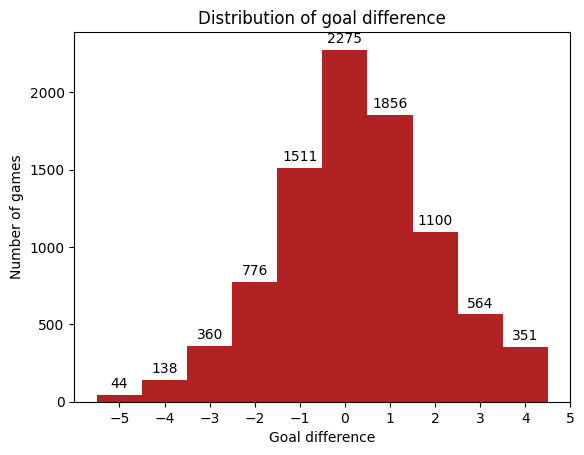

In [8]:
import pandas as pd
from matplotlib import pyplot as plt
df = pd.read_csv("model_matrix.csv")
df = df[abs(df.iloc[:,-1])<=5] #remove outliers, keep <=5 goal difference games
X, y  = df.iloc[:,:-1], df.iloc[:,-1]

plt.bar_label(plt.hist(y,bins = range(-5,6),align='left',color="firebrick")[2],padding=3)
plt.xticks(range(-5,6))
plt.ylabel("Number of games")
plt.xlabel("Goal difference")
plt.title("Distribution of goal difference")

In [13]:
import pandas as pd
df = pd.read_csv("model_matrix.csv")
df = df[abs(df.iloc[:,-1])<=5] #remove outliers, keep <=5 goal difference games
X, y  = df.iloc[:,:-1], df.iloc[:,-1]

obvious = ['OG', 'Gls', 'GA','Ast',
           #own goal, goals, goals against, penalty kick, corner kick, throw in, free kick, assist
           'xG', "PSxG",'GCA', "SCA", "npxG","xAG","xA","SoTA","Save%",
           #xg, goal creating actions
           'SoT',"xAG.1"]
reduntant = ["CrdY.1","CrdR.1","Off.1",'Ast.1']
deletable= [i+"_away" for i in obvious+reduntant]+ [i+"_home" for i in obvious+reduntant]
home_g, away_g = X["Gls_home"]+X['OG_away'], X["Gls_away"]+X['OG_home']
X = X.drop(columns=deletable)


## Class Imbalance Problem
1. SMOTE ADASYN
2. TABGAN

The question of augmenting first or feature select first

1. augment, feature select
2. feature select, augment
3. feature select, weighted loss

In [14]:
from imblearn.over_sampling import SMOTE
#oversample smote to balance the data
X,y = SMOTE().fit_resample(X, y)

## Feature Selection
Functioning as an EDA procedure, I use Mutual Information to see variance between features and analyze the most related columns to y. 


Index(['Att Pen_away', 'Sh_away', 'KP_away', 'Att Pen_home', 'KP_home',
       'CPA_away', 'Sh_home', 'Cmp.2_home', 'PPA_home', 'Att.1.1_away',
       ...
       'PKwon_home', 'Cmp%.3_home', 'Cmp%.3_away', 'PKwon_away', 'CrdR_home',
       'CrdR_away', 'Str_home', '2CrdY_away', '2CrdY_home', 'Str_away'],
      dtype='object', length=234)

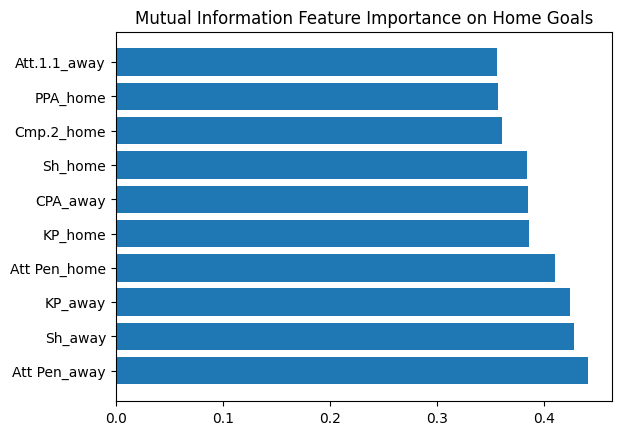

In [15]:
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
away, end = 136, 130
ranges = np.r_[:end, away:away+end]
a = pd.DataFrame(mutual_info_classif(X, y)).transpose()
a.columns = X.columns
a.index = pd.Index(["mi"])
"""select the 5 main features"""
c = a.sort_values(by="mi",axis=1,ascending=False)
plt.barh(c.columns[:10],c.iloc[0,:10])
plt.title("Mutual Information Feature Importance on Home Goals")
c.columns

In [27]:
#calculate the features using sequential search
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
linear = LinearRegression()

Selector = SequentialFeatureSelector(linear, n_features_to_select=5, direction="forward")
Selector.fit(X, y)
X.columns[Selector.get_support()]

Index(['KP_home', 'Crs_home', 'Att Pen_home', 'KP_away', 'CPA_away'], dtype='object')

<BarContainer object of 20 artists>

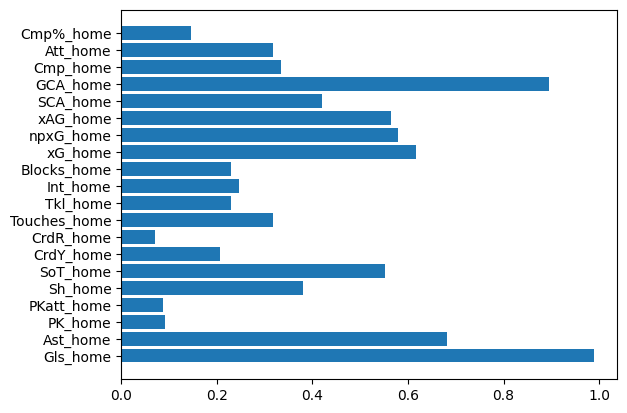

In [651]:
a = mutual_info_classif(X, y)
#compute mutual information with first two columns and the target variable
b = pd.DataFrame(a[ranges].transpose(),columns=["mi"])
b.index = X.columns[ranges]
b.sort_values(by="mi",ascending=False)
plt.barh(b.index[0:20],b.iloc[:20,0])

In [716]:
#split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.loc[:,c.columns[:5]],y, test_size=.2,random_state=42)

In [2]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2,random_state=42)

In [728]:
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso
mod1 = LinearRegression().fit(X_train, y_train)
a = pd.Series(mod1.coef_)
a.index = X_train.columns
a.sort_values(ascending=False)

mod2 = LogisticRegression().fit(X_train, y_train)
mod2.score(X_test, y_test)

0.26016713091922006

0.249025069637883


0.09929902419994087

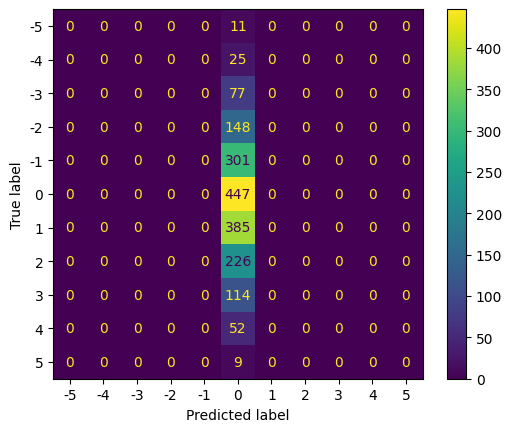

In [729]:
'''
train a MLP model on X_train, y_train and test on X_test, y_test
    15.8s
    0.4919 accuarcy
'''
from sklearn.neural_network import MLPClassifier
mod3 = MLPClassifier(hidden_layer_sizes=(100,64,16), max_iter=1000).fit(X_train, y_train)
mod3_prediction = mod3.predict(X_test)
print(mod3.score(X_test, y_test))
#draw the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,accuracy_score, f1_score
cm = confusion_matrix(y_test, mod3_prediction)
ConfusionMatrixDisplay(cm, display_labels=[-5,-4,-3,-2,-1,0,1,2,3,4,5]).plot()
f1_score(y_test, mod3_prediction, average="weighted")

0.24233983286908078


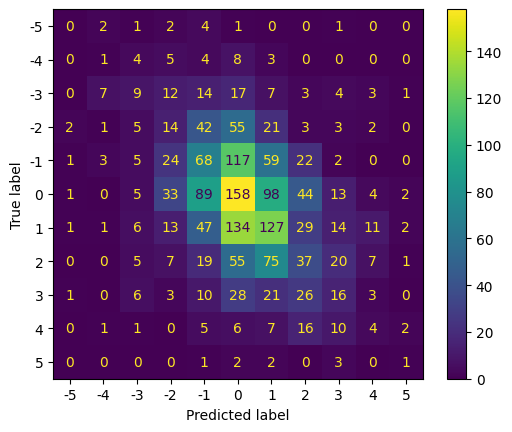

In [724]:
#train an xgboost model 
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
le = LabelEncoder()
bst = XGBClassifier(n_estimators=10, max_depth=10, learning_rate=0.01, objective='multi:softmax')
# fit model
bst.fit(X_train.to_numpy(), le.fit_transform(y_train))
y_predicted = bst.predict(X_test.to_numpy())
print(bst.score(X_test.to_numpy(), le.fit_transform(y_test)))
ConfusionMatrixDisplay(confusion_matrix(y_test, le.inverse_transform(y_predicted)),display_labels=[-5,-4,-3,-2,-1,0,1,2,3,4,5]).plot()

In [174]:
"""
21s for extracting 3 principal components and using xgb classifier

"""
import sklearn
kernelchoice = ["linear", "poly", "rbf", "sigmoid", "cosine"]
accuracy_list = {}
for i in kernelchoice:
    pca = sklearn.decomposition.KernelPCA(n_components=5, kernel = i)
    X_train1, X_test1, y_train1, y_test1 = train_test_split(pca.fit_transform(X),y,test_size = .2,random_state = 42)
    mod_temp = XGBClassifier(n_estimators=10, max_depth=10, learning_rate=0.01, objective='multi:softmax')
    mod_temp.fit(X_train1,le.transform(y_train1))
    accuracy_list[i]=  mod_temp.score(X_test1,le.transform(y_test1))
accuracy_list

{'linear': 0.22729805013927576,
 'poly': 0.21448467966573817,
 'rbf': 0.2128133704735376,
 'sigmoid': 0.249025069637883,
 'cosine': 0.2211699164345404}

Index(['Save%_away', 'Ast.1_home', 'Ast.1_away', 'Save%_home', 'PSxG_away',
       'PSxG_home', 'SoTA_away'],
      dtype='object')

Logisitic Regression training accuracy: 0.1433456825306355
Logisitic Regression testing accuracy: 0.14017094017094017


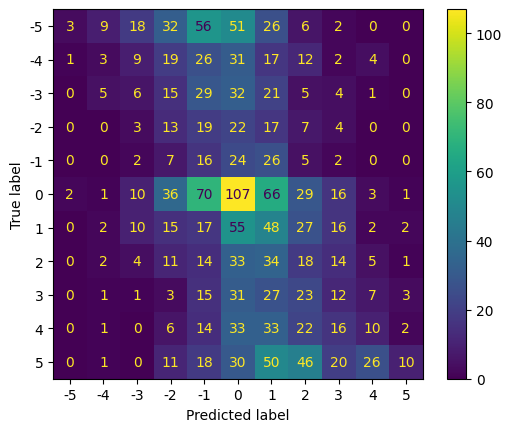

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X.loc[:,c],y,test_size=.2,random_state=42) 
mod_features_1 = LogisticRegression(multi_class='multinomial', solver='newton-cg', class_weight = 'balanced').fit(X_train,y_train)
print("Logisitic Regression training accuracy:", mod_features_1.score(X_train,y_train))
print("Logisitic Regression testing accuracy:", mod_features_1.score(X_test,y_test))

a = pd.concat([pd.DataFrame(mod_features_1.predict(X_test)),pd.DataFrame(y_test)], axis=1)
mod_features_1.classes_ = mod_features_1.classes_.astype(int)
ConfusionMatrixDisplay(confusion_matrix(pd.DataFrame(mod_features_1.predict(X_test)),pd.DataFrame(y_test)),display_labels=mod3.classes_).plot()

In [40]:
from tabgan.sampler import OriginalGenerator, GANGenerator, ForestDiffusionGenerator

def tabgan(resultmatrix, resulty):
    xtr, xte, ytr, yte = train_test_split(resultmatrix,resulty,test_size=0.34,random_state=42)
    
    #CTGAN
    new_train, new_target = GANGenerator(gen_x_times=1, cat_cols=None,
            bot_filter_quantile=0.001, top_filter_quantile=0.999, is_post_process=True,
            adversarial_model_params={
                "metrics": "AUC", "max_depth": 2, "max_bin": 100, 
                "learning_rate": 0.02, "random_state": 42, "n_estimators": 100,
            }, pregeneration_frac=2, only_generated_data=False,
            gen_params = {"batch_size": 500, "patience": 25, "epochs" : 500,}).generate_data_pipe(xtr, ytr, xte, 
                                                                                                    deep_copy=True, only_adversarial=False, use_adversarial=True)
    return new_train, new_target

/opt/homebrew/lib/python3.10/site-packages/_ctgan/synthesizer.py:7: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [110]:
#augment
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import ADASYN
import math
def smote(x, y):
    # Synthetic Minority Over-samping Technique
    # 
    # sampling_strategy: determines the portion of samples to 
    #                    generate with respect to the majority class
    # k_neighbors : number of neighbors to be considered for each sample
    
    # For this example, only 1% of minoirty samples are considered
    k_neighbors = math.ceil(sum(y) * 0.01)
      
    smote = SMOTE(sampling_strategy="auto", 
                  k_neighbors=k_neighbors)
    x, y = smote.fit_resample(x, y)
    
    return x, y
    
def bordersmote(x, y):
    # Borderline-SMOTE
    # 
    # sampling_strategy: determines the portion of samples to 
    #                    generate with respect to the majority class
    # k_neighbors : number of neighbors to be considered for each sample
    # m_neighbors : number of neighbors to consider to determine if a sample is danger
    
    # For this example, only 1% of minoirty samples are considered
    k_neighbors = math.ceil(sum(y) * 0.01)
    m_neighbors = math.ceil(sum(y) * 0.01)
    
    bordersmote = BorderlineSMOTE(sampling_strategy="auto", 
                                  k_neighbors=k_neighbors, 
                                  m_neighbors=m_neighbors)
    
    x, y = bordersmote.fit_resample(x, y)
    
    return x, y
    
def adasyn(x, y):

    # Adaptive Synthetic
    # 
    # sampling_strategy: determines the portion of samples to 
    #                    generate with respect to the majority class
    # n_neighbors : number of neighbors to be considered for each sample
    
    # For this example, only 1% of minoirty samples are considered
    n_neighbors = math.ceil(sum(y) * 0.01)
    
    adasyn = ADASYN(sampling_strategy=1,
                   n_neighbors=n_neighbors)
    x, y = adasyn.fit_resample(x, y)

    return x, y

X, y = torch.Tensor(smote(X, y)[0]), torch.Tensor(smote(X, y)[1])[:,None]
y.unique(return_counts=True)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
y.unique(return_counts=True)

ModuleNotFoundError: No module named 'imblearn'

,Gls_home,Gls_away
0,4.0,3.0
1,3.0,3.0
2,0.0,2.0
3,1.0,0.0
4,2.0,3.0
...,...,...
9022,1.0,1.0
9023,5.0,0.0
9024,2.0,3.0
9025,4.0,0.0


In [ ]:
X = X.nan_to_num(nan=0)
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import f1_score, accuracy_score

mod1 = LinearRegression().fit(X_train,y_train)
mod2 = ElasticNet(alpha = 1, l1_ratio=1/2).fit(X_train,y_train)
print(
      "Linear Regression r^2:", (mod1.score(X_test,y_test)),
      "\n \t\t accuracy after rounding:",accuracy_score(y_test,mod1.predict(X_test).round().astype(int)), 
      "\n \t\t f1 score:", f1_score(y_test,mod1.predict(X_test).round().astype(int),average='weighted'))
print("Elastic Net",(mod2.score(X_test,y_test)))

a = pd.DataFrame(mod2.coef_).transpose()
a.columns = finalmatrix.columns
a.sort_values(by=0,axis=1,ascending=False).loc[:, (a != 0).all()]

Linear Regression r^2: 0.7589927001465637 
 		 accuracy after rounding: 0.2222429906542056 
 		 f1 score: 0.228691725117185
Elastic Net 0.5792002704422321


,Att Pen_1,PPA_1,Save%_1,KP_1,SCA_1,Cmp_1,Rec_1,PrgR_1,CPA_1,Live_1,...,TB_2,Live_2,Cmp_2,Rec_2,CPA_2,KP_2,Sh_2,SCA_2,Att Pen_2,Save%_2
0,0.253025,0.169923,0.162395,0.159856,0.124616,0.099787,0.087455,0.076945,0.072419,0.059845,...,-0.044582,-0.055045,-0.063138,-0.07778,-0.08261,-0.092611,-0.141206,-0.143453,-0.179717,-0.205876


Logisitic Regression training accuracy: 0.952755905511811
Logisitic Regression testing accuracy: 0.9627659574468085


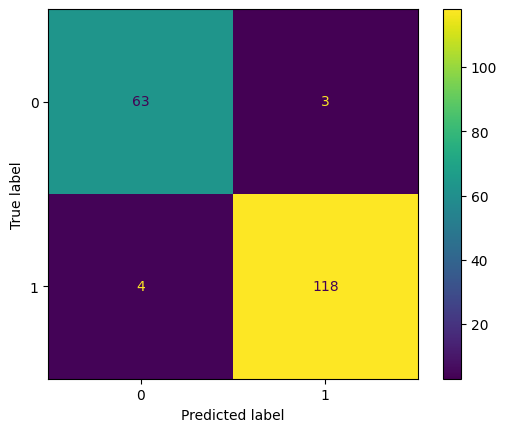

In [ ]:
# Logisitc Regression as a classification problem
X = X.nan_to_num(nan=0)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
mod3 = LogisticRegression(multi_class='multinomial', solver='lbfgs').fit(X_train,y_train)
print("Logisitic Regression training accuracy:", mod3.score(X_train,y_train))
print("Logisitic Regression testing accuracy:", mod3.score(X_test,y_test))

a = pd.concat([pd.DataFrame(mod3.predict(X_test)),pd.DataFrame(y_test)],axis=1)
mod3.classes_ = mod3.classes_.astype(int)
ConfusionMatrixDisplay(confusion_matrix(pd.DataFrame(mod3.predict(X_test)),pd.DataFrame(y_test)),display_labels=mod3.classes_).plot()

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
k1, k2 = 15, 30
myx = X_train.iloc[:,np.r_[k1:k1+1, k2:k2+1]]
myy = y_train

x_min, x_max = myx.iloc[:, 0].min() - 1, myx.iloc[:, 0].max() + 1
y_min, y_max = myx.iloc[:, 1].min() - 1, myx.iloc[:, 1].max() + 1

C = 1.0

svc = svm.SVC(kernel='linear', C=C).fit(myx, myy)
rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C).fit(myx, myy)
poly_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(myx, myy)
lin_svc = svm.LinearSVC(C=C).fit(myx, myy)

# title for the plots
titles = ['SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel']

h = 0.2
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

for i, clf in enumerate((svc, lin_svc, rbf_svc, poly_svc)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    # Plot also the training points
    plt.scatter(myx.iloc[:20, 0], myx.iloc[:20, 1], c=myy[:20], cmap=plt.cm.coolwarm)
    plt.xlabel(X_train.columns[k1])
    plt.ylabel(X_train.columns[k2])
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])
    plt.legend()
plt.show()

In [5]:
import numpy as np
from sklearn import svm
k1, k2 = 15, 30
myx = X_train.iloc[:,np.r_[k1:k1+1, k2:k2+1]]
myy = y_train

x_min, x_max = myx.iloc[:, 0].min() - 1, myx.iloc[:, 0].max() + 1
y_min, y_max = myx.iloc[:, 1].min() - 1, myx.iloc[:, 1].max() + 1

C = 1.0

svc = svm.SVC(kernel='linear', C=C).fit(myx, myy)
rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C).fit(myx, myy)
poly_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(myx, myy)
lin_svc = svm.LinearSVC(C=C).fit(myx, myy)

/opt/homebrew/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [17]:

for i in map(int,list(str(123))):
    print(i)

1
2
3


In [730]:
from torch.utils.data import DataLoader
bs = 1
train_loader = DataLoader(dataset = X_train, batch_size=bs)
train_labelloader = DataLoader(dataset = y_train, batch_size=bs)